<a href="https://colab.research.google.com/github/Joe-Johnson-23/Eigenfaces/blob/main/eigenfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eigenfaces

Eigenfaces is a facial recognition technique based on Principal Component Analysis (PCA), a mathematical approach that reduces high-dimensional data while preserving the most significant features. It is used for face recognition by identifying patterns in facial images  and representing them with a lower-dimensional feature set.

At its core, the Eigenfaces method relies on eigenvectors, which are the "directions" in which the data varies the most. When applied to facial recognition these eigenvectors represent standardized facial features. Essentially, they act as building blocks for reconstructing any face using a weighted combination of these features. This process not only reduces the complexity of the data but also enhances the model’s ability to generalize and recognize faces under varying conditions.

A high-level overview of how this works is that we are trying to recognize faces, but instead of memorizing every tiny detail, we learn just the most important features and use them to tell faces apart. Some of the main steps, which I will delve into deeper later, include preprocessing images, constructing the covariance matrix, computing eigenvectors and eigenvalues, and projecting facial images onto a reduced feature space.

In [20]:
# Install required packages
!pip install opencv-python-headless numpy matplotlib scikit-learn

# Import libraries
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [21]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# path to archive folder
folder_path = "/content/drive/My Drive/archive"


# Path to your custom images folder
folder_path_images = "/content/drive/My Drive/images"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



#Step 1: Preparing Facial Images
To analyze facial images with Eigenfaces, the first step is to convert each image into a numerical format. Each pixel in an image is represented as a numerical value, and by flattening a 2D image array (e.g., 100x100 pixels) into a 1D row vector, we simplify the data into a form that can be used in mathematical operations. When we have multiple facial images, we stack these vectors into a large matrix, where each row represents a different fac.


In [22]:
# Step 1: Load Face Images
def preprocess_image(img):
    # 1. Apply histogram equalization first (works on 0-255 range)
    img_equalized = cv2.equalizeHist(img)

    # 2. Then normalize to [0-1] range
    img_normalized = img_equalized.astype(float) / 255.0

    return img_normalized

def load_images_from_folder(base_folder, img_size=(100, 100)):
    images = []
    filenames = []
    labels = []

    print("Loading images...")
    total_subjects = len([f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))])

    # Sort folders numerically instead of alphabetically
    subject_folders = sorted(os.listdir(base_folder),
                           key=lambda x: int(x.replace('s', '')) if x.startswith('s') else 0)

    for i, subject_folder in enumerate(subject_folders, 1):
        subject_path = os.path.join(base_folder, subject_folder)
        if not os.path.isdir(subject_path):
            continue

        print(f"Processing subject {i}/{total_subjects}: {subject_folder}")
        # Count images for this subject
        subject_images = 0

        for filename in os.listdir(subject_path):
            img_path = os.path.join(subject_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size)
                img = preprocess_image(img)  # Add preprocessing
                images.append(img.flatten())
                filenames.append(os.path.join(subject_folder, filename))
                labels.append(int(subject_folder.replace('s', '')))
                subject_images += 1

        print(f"  → Processed {subject_images} images for {subject_folder}")

    print(f"\nCompleted! Total: {len(images)} images from {total_subjects} subjects")
    return np.array(images), filenames, np.array(labels)

# Load the images
images, filenames, labels = load_images_from_folder(folder_path)
print(f"Loaded {len(images)} images from {len(set(labels))} different subjects")

# After loading all images and before computing PCA
test_indices = []
for i, filename in enumerate(filenames):
    # Find image #5 for each subject
    if '/5.pgm' in filename:  # This will match s1/5.pgm, s2/5.pgm, etc.
        test_indices.append(i)

# Save test images and their info
test_images = images[test_indices].copy()
test_filenames = [filenames[i] for i in test_indices]

# Remove test images from training data
images = np.delete(images, test_indices, axis=0)
filenames = np.delete(filenames, test_indices)
labels = np.delete(labels, test_indices)

print("\nTest images removed:")
print(f"Test images: {test_filenames}")



Loading images...
Processing subject 1/40: s1
  → Processed 10 images for s1
Processing subject 2/40: s2
  → Processed 10 images for s2
Processing subject 3/40: s3
  → Processed 10 images for s3
Processing subject 4/40: s4
  → Processed 10 images for s4
Processing subject 5/40: s5
  → Processed 10 images for s5
Processing subject 6/40: s6
  → Processed 10 images for s6
Processing subject 7/40: s7
  → Processed 10 images for s7
Processing subject 8/40: s8
  → Processed 10 images for s8
Processing subject 9/40: s9
  → Processed 10 images for s9
Processing subject 10/40: s10
  → Processed 10 images for s10
Processing subject 11/40: s11
  → Processed 10 images for s11
Processing subject 12/40: s12
  → Processed 10 images for s12
Processing subject 13/40: s13
  → Processed 10 images for s13
Processing subject 14/40: s14
  → Processed 10 images for s14
Processing subject 15/40: s15
  → Processed 10 images for s15
Processing subject 16/40: s16
  → Processed 10 images for s16
Processing subjec


## Dataset Structure
- 40 different subjects (folders s1 to s40)
- 10 different images per subject
- Total of 400 grayscale images
- Remove one image per subject in dataset to use for testing

## Image Processing Steps
1. **Load**: Read each image in grayscale format
2. **Resize**: Standardize all images to 100 x 100 pixels
3. **Flatten**: Convert 2D images (100 x 100) to 1D arrays

## Why These Steps?
- **Grayscale**: Reduces complexity while keeping important facial features
- **Standard Size**: Ensures all images can be compared directly
- **Flattening**: Prepares images for PCA (eigenfaces) computation


 By stacking these vectors as rows in matrix A, we prepare the data for PCA, where each column represents a unique face. This matrix construction is crucial for calculating the covariance matrix and ultimately deriving the eigenvectors (i.e., the Eigenfaces).


Displaying images of subject s2:


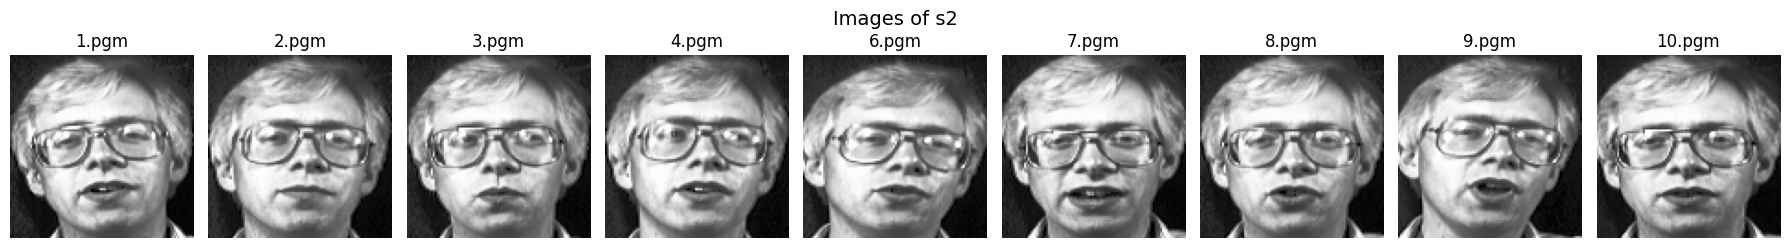

In [23]:
# plot all 10 images of one person
def plot_subject_images(images, filenames, subjects=['s2']):
    # Get images for each subject
    subject_images = {subject: [] for subject in subjects}
    subject_files = {subject: [] for subject in subjects}

    # First collect all images and filenames
    for img, fname in zip(images, filenames):
        subject = fname.split('/')[0]
        if subject in subjects:
            subject_images[subject].append(img)
            subject_files[subject].append(fname)

    # Create subplot for each subject
    for subject in subjects:
        # Sort the images and filenames based on the numeric part of the filename
        paired_data = list(zip(subject_images[subject], subject_files[subject]))
        paired_data.sort(key=lambda x: int(x[1].split('/')[1].split('.')[0]))
        sorted_images, sorted_files = zip(*paired_data)

        n_images = len(sorted_images)
        fig, axes = plt.subplots(1, n_images, figsize=(n_images * 2, 2.5))
        fig.suptitle(f'Images of {subject}', fontsize=14)

        for i, (img, fname) in enumerate(zip(sorted_images, sorted_files)):
            axes[i].imshow(img.reshape(100, 100), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(fname.split('/')[1])

        plt.tight_layout()
        plt.show()

# Show images of s2
print("Displaying images of subject s2:")
plot_subject_images(images, filenames)




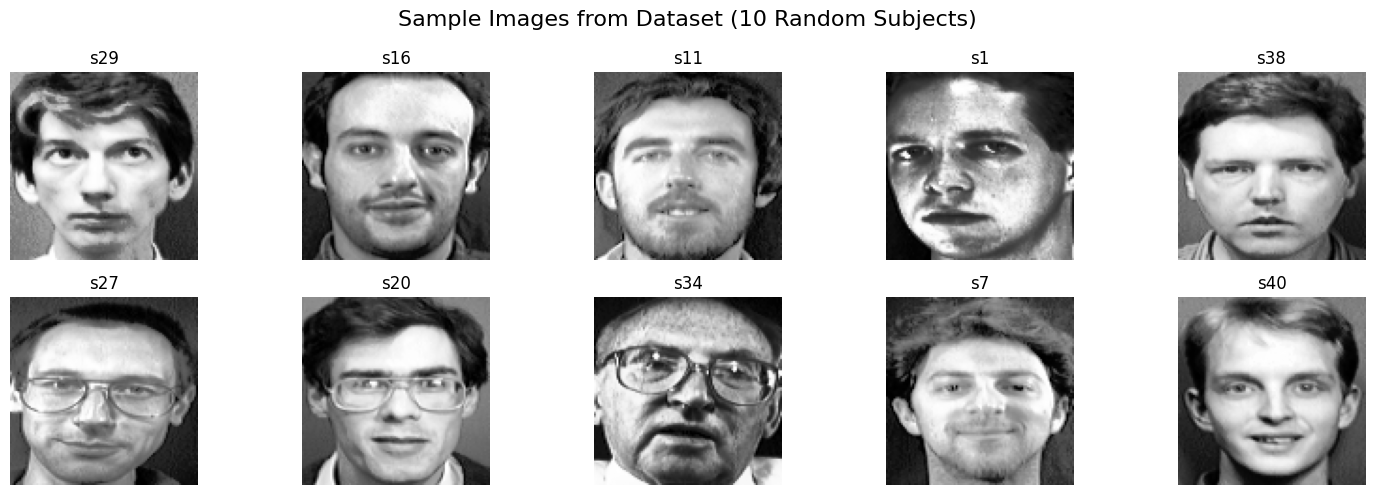

In [24]:
def show_sample_faces(images, filenames, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    fig.suptitle('Sample Images from Dataset (10 Random Subjects)', fontsize=16)

    # Get unique subjects and randomly select 10
    unique_subjects = sorted(list(set(f.split('/')[0] for f in filenames)))
    random_subjects = np.random.choice(unique_subjects, 10, replace=False)

    # Show one image each from 10 random subjects
    for row in range(2):
        for col in range(num_samples):
            subject = random_subjects[row * num_samples + col]
            # Find first image of this subject
            idx = next(i for i, f in enumerate(filenames) if f.startswith(subject + '/'))

            axes[row, col].imshow(images[idx].reshape(100, 100), cmap='gray')
            axes[row, col].set_title(f'{subject}')
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_faces(images, filenames)


# Step 2 - Mean Face Computation

To identify common features among all the facial images in our dataset, we need to compute a "prototypical" or mean face. This average face acts as a baseline, highlighting the shared characteristics of the dataset while allowing us to focus on unique variations in individual faces.

The mean face is computed by averaging each pixel value across all images. Imagine we have three images, and the pixel at a specific coordinate is [20, 30, 50] across these images. By averaging these values (20 + 30 + 50) / 3 = 33 we find that the mean face's pixel at this coordinate would be 33. Repeating this process for every pixel generates the entire mean face.  


The mean face vector μ (mu) is calculated as:

$$\mu = \frac{1}{M} \sum_{i=1}^M X_i$$


Where:
* $M$ is the total number of images.
* $X_i$ is the vector representation of the i-th face.
* The resulting $μ$ is a vector with the same dimensions as the input face vectors.




The mean face is the average of all training images. It:
- Represents the "typical" face in our dataset
- Is subtracted from each image to center the data
- Helps highlight differences between faces


Mean Face Shape: (10000,)
Mean Face: Average of all faces, centers the data

Centered Data Shape: (360, 10000)
Centered Data: Each face minus mean face to remove common features


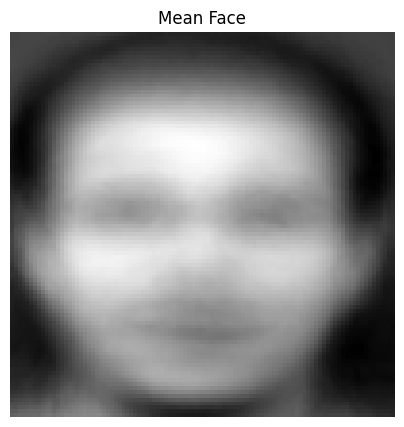

In [25]:
# Compute mean face
mean_face = np.mean(images, axis=0)
print(f"\nMean Face Shape: {mean_face.shape}")
print("Mean Face: Average of all faces, centers the data")

# Subtract mean face from all images
A = images - mean_face  # Mean-centered images
A = images # PCA will subtract mean inherently
print(f"\nCentered Data Shape: {A.shape}")
print("Centered Data: Each face minus mean face to remove common features")

# Visualize mean face
plt.figure(figsize=(5, 5))
plt.imshow(mean_face.reshape(100, 100), cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()


Why?

After computing the mean face, we subtract this mean from each image vector to normalize the dataset. This step shifts the data so that we are focusing on the differences from the average face, which is crucial for PCA to effectively identify the unique features of each face. This helps us learn what makes each face different. Thus, each vector in the matrix representing all the faces becomes a new vector that shows the differences from the average face. Mathematically, this transformation is:

$$Φ_i = X_i − μ$$

Where $Φ_i$ is the mean-subtracted face vector. By performing this operation, we prepare the data for the next step—computing the covariance matrix and extracting the eigenvectors (Eigenfaces).


Resulting in a matrix of mean-subtracted vectors:
$$Φ = X − μ$$

Φ (Phi) is the matrix of normalized face vectors  
X is the original data matrix with each column as a face vector  
μ is the mean face vector broadcasted across all columns.


# Step 3: Computing the Covariance Matrix

- Note on Matrix Notation: In the following mathematical descriptions, we use the traditional column-major format where vectors are represented as columns and faces are stacked as columns in matrix A. However, in the actual implementation, we use row-major format where each face is a row vector, as this aligns with scikit-learn's expectations and is more efficient for matrix operations in most programming languages. This means that while our mathematical notation shows an N×M matrix A (where N is the number of pixels and M is the number of faces), our implementation will actually use an M×N matrix where each row represents a face.  



To capture the relationships between pixel variations across our facial images, we compute a covariance matrix. This matrix helps us understand which pixels change together, revealing patterns in facial features. For example, if a sharper jawline often coincides with a certain lip shape, the covariance matrix will reflect this relationship.



The covariance matrix C is computed as:

$$C = \frac{1}{M} AA^T$$

### Where:

- C is an N × N matrix (N is the number of pixels, e.g., 10,000 for a 100 x 100 image).
- A is an N × M matrix containing mean-subtracted face vectors as columns.
- Aᵀ is the transpose of A.

---
---

## Let's explain how the Covariance Matrix Works!
The goal is to understand how each pixel changes in relation to all other pixels across the images. This means calculating the covariance between the pixel values of two pixels across all images.
The covariance between two pixels tells you how much the intensity of one pixel changes in relation to the intensity of another pixel, over all images.
If two pixels have high covariance, it means they tend to change in a similar way across the dataset. For example, if one pixel is bright when another pixel is bright, and both are dark when the other is dark, their covariance will be high. This is useful for understanding how different parts of the face (like the eyes, nose, etc.) correlate with each other across different faces.  

When we multiply
$A$ by its $A^T$, we are essentially summing the pairwise correlations of the pixels over all images. This tells us how pixel intensities relate to each other in terms of their variance across the images.

Each column of $A$ is a mean-subtracted vector that represents one face (after subtracting the mean image from each face).
* $A^T$ is the transpose of $A$, which flips rows and columns. By multiplying $A$ by its transpose $A^T$, you're essentially computing how each image (in the form of a vector) relates to every other image, pixel-wise.

* The, $\frac{1}{M}$, is simply a normalization step. You are effectively averaging the covariance over all the images in your dataset. This ensures the covariance matrix captures the overall relationship between pixels, not just the sum of individual deviations.

Thus,  
$A×A^T$ computes the pairwise relationships (covariances) between the different pixels (or features) across the faces.
Dividing by $M$ normalizes the covariance calculation, giving us an average covariance.
The result is the covariance matrix $C$, which captures the relationships between pixel intensities across all the images in the dataset.

---
---  
### Computational Challenge:

Directly computing eigenvectors of C is computationally expensive due to its large size (N × N). Instead, we use a computational trick:

Instead of computing eigenvectors of C = AAᵀ (N × N),
We compute eigenvectors of a much smaller matrix AᵀA (M × M, where M is the number of images).

Why This Works:
Matrix Size Comparison:
- AAᵀ: Results in a large matrix of size N × N.
- AᵀA: Results in a smaller matrix of size M × M.
- Since M ≪ N (fewer images than pixels per image), using AᵀA is much more efficient.

---


### **Key Difference: Why is One Matrix $N * N$ and the Other $M * M$?**  

The difference in matrix dimensions arises from how matrix multiplication works:  

---

#### **1. The Large Matrix: $AA^T$ is $N * N$**  

- Matrix A is of size $N * M$, where:  
  - $N$ = Number of pixels per image (e.g., 10,000 for a 100 × 100 image).  
  - $M$ = Number of images (e.g., 360 faces).  

- Multiplication Steps:  

$$
AA^T = (N \times M) \cdot (M \times N) = N \times N
$$  

- Outcome: This produces a large covariance matrix of size $N * N$, which can be computationally expensive to process.  

---

#### **2. The Smaller Matrix: $A^T A$ is $M * M$**  

- Matrix $A^T$ is of size $M * N$, and $A$ remains $N * M$.  

- Multiplication Steps:  

$$
A^T A = (M \times N) \cdot (N \times M) = M \times M
$$  

- Outcome: This results in a much smaller matrix of size $M * M$.  

---

### **Why Is This Important?**  
Since $M \ll N$ (i.e., there are far fewer images than pixels per image), solving the eigenvalue problem for the smaller matrix $A^T A$ is:  

- Computationally Efficient: Reduces complexity from $O(N^3)$ to $O(M^3)$.
- For the large covariance matrix (N × N): O(N³)
-- N = 10000 pixels: 10000³ = 1,000,000,000,000 operations
- For the smaller matrix (M × M): O(M³)
-- With M = 360 faces: 360³ = 46,656,000 operations

### **Why we can do this?**
Shared Nonzero Eigenvalues:
A key result from linear algebra tells us that:
- The nonzero eigenvalues of AAᵀ and AᵀA are the same.
- Once we find eigenvectors of AᵀA, we can reconstruct the eigenvectors for AAᵀ without needing to solve another eigenvalue problem.
- This means we solve for eigenvectors in
AᵀA first, then reconstruct the Eigenfaces.
---
#### ***Despite the difference in dimensions, both matrices essentially capture the same covariance structure and therefore the same nonzero eigenvalues. This is because the rank of both matrices is the same (the rank depends on the linear independence of the columns of $A$, not on the size of the matrix).  
-- We only have 360 samples (faces)  
-- We cannot extract more linearly independent components than we have samples  
-- Thus, the extra dimensions in the larger matrix represent redundant or empty dimensions  

---
## Summary:
- The resulting eigenfaces are derived from the eigenvectors of the covariance matrix and represent the principal components of facial variation.
- By projecting facial images onto these eigenfaces, we can create a compact, feature-rich representation of each face, enabling efficient and accurate facial recognition.

# Computing Eigenfaces using PCA
Principal Component Analysis (PCA) finds the main directions of variation in our face data. In this context:
- Each eigenface is a principal component
- Each eigenface represents a different type of variation between faces
- First eigenfaces capture major variations (like lighting, facial structure)
- Later eigenfaces capture more subtle details

## Parameters:
- Using 150 components (eigenfaces)
- This means each face will be represented by 150 numbers instead of 10,000 pixels




## **Step 4: Calculate the Eigenvectors (Eigenfaces)**  

### **Conceptual Overview:**  

To recognize faces, we need to calculate eigenvectors (also called Eigenfaces) from the covariance matrix.  

- These Eigenfaces act as the building blocks of all faces in the dataset.  
- Each Eigenface represents a significant pattern, like the overall shape of a face, or whether a person has a wide forehead or a small nose.  
- Every individual face is essentially a combination of these Eigenfaces with varying weights.  

---

### **Mathematical Approach:**  

To compute Eigenfaces, we solve the eigenvalue problem:  

$$
A^TA v = \lambda v
$$  

Where:  
- $v$ is the eigenvector.  
- \$\lambda\$ is the eigenvalue.  
- $A^TA$ is the smaller covariance matrix.  

---
## Key Concepts:
- Eigenvalue: The eigenvalue
λ associated with an eigenvector indicates the amount of variance (or information) that is captured by that eigenvector (or principal component). A larger eigenvalue means that the corresponding eigenvector explains more of the variance in the data.
- Eigenvector: The eigenvector $v$ associated with a given eigenvalue is a direction in the feature space. In PCA, these eigenvectors represent the principal components of the data — the directions along which the data varies the most.

## Summary
- You have a dataset of face images. When you compute the covariance matrix of the pixel values across all the images, you are quantifying how each pixel varies and how different pixels are correlated.
- By finding the eigenvectors of this covariance matrix, you get the Eigenfaces (the principal components). These Eigenfaces correspond to the directions of maximum variance in the data, i.e., they capture the most important variations in the facial images (like variations in lighting, facial expressions, or head orientation).
- The eigenvalues tell you how much variance each of the Eigenfaces explains. The larger the eigenvalue, the more important that Eigenface is in explaining the variations in the dataset.
- By selecting only the Eigenfaces with the largest eigenvalues, you retain the most significant features of the face images, and discard the smaller variations (those associated with smaller eigenvalues).

---
## Converting Small Matrix  $A^TA$ Eigenvectors to Eigenfaces
- After finding the eigenvectors of
$A^T A$, you can then reconstruct the eigenvectors of
$AA^T$ using the fact that both matrices share the same nonzero eigenvalues.
- Specifically, the eigenvectors of $A^T A$ provide a basis in the feature space (the space of the data features or pixels), and you can use this to compute the corresponding eigenvectors in the data space.
---

Once we compute eigenvectors $v_i$ of $A^T A$, we convert them into Eigenfaces using:  

$$
u_i = A v_i
$$  

Where:  
- $u_i$ is the Eigenface.  
- $A$ is the mean-subtracted data matrix.  

---
## Feature Space vs. Data Space:
- The data space is where the original data (images, for instance) exists. In the case of face recognition, this would be the space of actual face images where each image is represented by a vector of pixel values.
- The feature space is a transformed space, where the dimensions (principal components) are the most important directions of variation in the data.

## Why Multiply by $A$?:
- Each eigenvector $v_1$ corresponds to a direction in the feature space, and multiplying it by $A$ maps this direction into the data space.
- In other words, you are transforming the abstract mathematical direction represented by the eigenvector $v_1$ into a concrete image (Eigenface) that we can understand and visualize.
- The resulting $u_1 = Av_1$ represents a linear combination of the original image data (which are stored in the columns of $A$), and this combination corresponds to a new face image that represents a "principal component" or the most important pattern of facial variation in the dataset.


---

### **Key Takeaways:**  

1. Eigenfaces (principal components) represent the most important variations in the face dataset.  
2. Sorting by Eigenvalues:  
   - Higher eigenvalues indicate the Eigenface captures more variance (i.e., more important features).  
3. Dimensionality Reduction:  
   - We select the top K Eigenfaces, where K is much smaller than N, to form a low-dimensional face space.  
   - This allows us to efficiently compare faces in a reduced feature space, enhancing recognition performance.  

---

### Also...  

When visualizing Eigenfaces, they might look strange or ghost-like because they represent abstract features rather than realistic faces. However, these abstract patterns are crucial for distinguishing between individual faces!  



Computing PCA with 150 components...

Using CustomPCA implementation...
Original face dimension: 10000 pixels
Reducing to 150 principal components

Fitting CustomPCA to images...
Using efficient method: computing 360×360 matrix instead of 10000×10000
Explained variance ratio: 93.53%

Generating eigenfaces...
Eigenfaces Shape: (150, 10000)
Each eigenface is a direction of maximum variation

Computing face weights...
Face Weights Shape: (360, 150)
Each face is now represented by 150 weights instead of 10000 pixels

Comparing CustomPCA with sklearn's PCA implementation...
Using efficient method: computing 360×360 matrix instead of 10000×10000
Custom PCA explained variance ratio sum: 0.9353301657660626
Sklearn PCA explained variance ratio sum: 0.9345757934579717

Correlation between first eigenface: 0.9999999999999997

This means we can represent 93.53% of the variation
in the faces using just 150 dimensions instead of 10000 pixels,
which is a significant reduction while maintaining most 

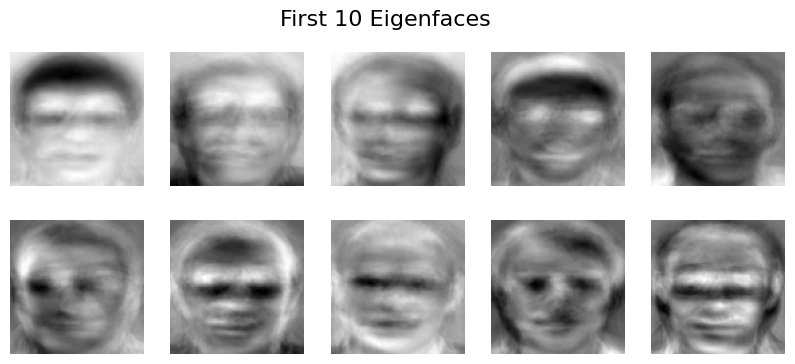

In [26]:
# CUSTOM PCA
class CustomPCA:
    def __init__(self, n_components, whiten=False):
        self.n_components = n_components
# Purpose of Whitening:
# Makes all principal components have equal variance
# Useful when different components have very different scales
        self.whiten = whiten
        self.components_ = None
        self.mean_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None


    def fit(self, X):

        # Center the data
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        n_samples, n_features = X_centered.shape

        # Check which approach is more efficient
        if n_samples < n_features:
            # Use the optimization trick (L = X*X^T)
            print(f"Using efficient method: computing {n_samples}×{n_samples} matrix instead of {n_features}×{n_features}")

            # Compute the smaller matrix L = X*X^T
            L = np.dot(X_centered, X_centered.T) / (n_samples - 1)

            # Eigen decomposition of the smaller matrix
            eigenvalues, eigenvectors_L = np.linalg.eigh(L)

            # Sort in descending order
            idx = np.argsort(eigenvalues)[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors_L = eigenvectors_L[:, idx]

            # Convert eigenvectors of L to eigenvectors of C
            # V = X^T * U * D^(-1/2)
            # Only keep non-zero eigenvalues
            positive_eigenvalues = eigenvalues > 1e-10
            eigenvalues = eigenvalues[positive_eigenvalues]
            eigenvectors_L = eigenvectors_L[:, positive_eigenvalues]

            # Convert eigenvectors
            scaling_factor = np.sqrt(n_samples - 1)
            eigenvectors = np.dot(X_centered.T, eigenvectors_L) / (np.sqrt(eigenvalues * scaling_factor))

            # Normalize the eigenvectors
            for i in range(eigenvectors.shape[1]):
                eigenvectors[:, i] = eigenvectors[:, i] / np.linalg.norm(eigenvectors[:, i])

        else:
            # Fall back to the original method for the unusual case where n_features < n_samples
            print(f"Using standard method: computing {n_features}×{n_features} matrix")
            cov_matrix = self.manual_covariance(X_centered)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

            # Sort in descending order
            idx = np.argsort(eigenvalues)[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]

        # Store components and explained variance
        self.components_ = eigenvectors[:, :self.n_components].T
        self.explained_variance_ = eigenvalues[:self.n_components].copy()
        total_var = eigenvalues.sum()
        self.explained_variance_ratio_ = self.explained_variance_ / total_var

        # Add whitening if enabled
        # Makes all principal components have equal variance
        # Useful when different components have very different scales
        # Divides each component by square root of its eigenvalue
        # Larger eigenvalues get divided by larger numbers
        # Result: all components contribute equally in terms of scale
        if self.whiten:
          # Scale each component by 1/sqrt(eigenvalue)
            self.components_ = self.components_ / np.sqrt(self.explained_variance_[:, np.newaxis])

        return self




    # Projects the input data onto the principal components (eigenfaces)
    # The resulting weights tell us how much each eigenface contributes to reconstructing a face
    # Each eigenface is a unit vector (direction) in pixel space
    # The dot product measures how much an image "points in the direction" of each eigenface
    # Mathematically: weight = Sum(image_pixel_i × eigenface_pixel_i)
    # Large positive weight: image strongly matches eigenface pattern
    # Large negative weight: image matches inverse of eigenface pattern
    # Small weight: image doesn't correlate with eigenface pattern
    def transform(self, X):
        X_centered = X - self.mean_
        if self.whiten:
            return np.dot(X_centered, self.components_.T)
        else:
            return np.dot(X_centered, self.components_.T)

    # Reconstructs the original face images from their eigenface representations
    # Useful for verifying the quality of the compression/reconstruction
    def inverse_transform(self, X_transformed):
        if self.whiten:
            # Unwhiten the data
            # Reverses the whitening process
            # Multiplies back by square root of eigenvalues
            # Restores original scale of components
            # Necessary to get back to original data space
            X_unwhitened = np.dot(X_transformed,
                                 self.components_ * np.sqrt(self.explained_variance_[:, np.newaxis]))
            return X_unwhitened + self.mean_
        else:
            return np.dot(X_transformed, self.components_) + self.mean_

    # For eigenfaces, if you have 100×100 pixel images:
    # Each pixel position is a feature
    # The covariance matrix will be 10000×10000
    # Entry (i,j) tells you how pixel i varies with pixel j across all images
    # If pixels i and j tend to be bright together or dark together, their covariance will be positive
    # If one tends to be bright when the other is dark, covariance will be negative
    def manual_covariance(self, X_centered):
        """
        Parameters:
            X_centered: centered data matrix (n_samples × n_features)
        Returns:
            covariance matrix (n_features × n_features)
        """
        n_samples = X_centered.shape[0]
        # Formula: (X^T * X) / (n-1)
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
        return cov_matrix



def compare_implementations(images, n_components=150):
    """
    Standalone function that compares CustomPCA with sklearn's PCA
    """
    from sklearn.decomposition import PCA

    # Our implementation
    custom_pca = CustomPCA(n_components=n_components)
    custom_pca.fit(images)
    custom_eigenfaces = custom_pca.components_
    custom_weights = custom_pca.transform(images)

    # Sklearn's implementation
    sklearn_pca = PCA(n_components=n_components)
    sklearn_pca.fit(images)
    sklearn_eigenfaces = sklearn_pca.components_
    sklearn_weights = sklearn_pca.transform(images)

    # Compare results
    print("Custom PCA explained variance ratio sum:",
          custom_pca.explained_variance_ratio_.sum())
    print("Sklearn PCA explained variance ratio sum:",
          sklearn_pca.explained_variance_ratio_.sum())

    # Compare eigenfaces
    eigenface_correlation = np.abs(np.corrcoef(
        custom_eigenfaces[0], sklearn_eigenfaces[0])[0,1])
    print("\nCorrelation between first eigenface:", eigenface_correlation)

    return custom_pca, sklearn_pca









# Compute PCA to Find Eigenfaces
n_components = 150  # Set to 150 components
print(f"\nComputing PCA with {n_components} components...")


# CustomPCA implementation
print("\nUsing CustomPCA implementation...")
pca = CustomPCA(n_components=n_components, whiten=True)
print(f"Original face dimension: {A.shape[1]} pixels")
print(f"Reducing to {n_components} principal components")

print("\nFitting CustomPCA to images...")
pca.fit(A)
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2%}")

print("\nGenerating eigenfaces...")
eigenfaces = pca.components_
print(f"Eigenfaces Shape: {eigenfaces.shape}")
print("Each eigenface is a direction of maximum variation")

print("\nComputing face weights...")
face_weights = pca.transform(A)
print(f"Face Weights Shape: {face_weights.shape}")
print(f"Each face is now represented by {n_components} weights instead of {A.shape[1]} pixels")

# Compare implementations to see which one performs better
print("\nComparing CustomPCA with sklearn's PCA implementation...")
custom_pca_comparison, sklearn_pca_comparison = compare_implementations(A, n_components=n_components)

print(f"""
This means we can represent {pca.explained_variance_ratio_.sum():.2%} of the variation
in the faces using just {n_components} dimensions instead of {A.shape[1]} pixels,
which is a significant reduction while maintaining most of the information.
""")


def plot_faces(faces, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4))
    fig.suptitle(title, fontsize=16)

    # Handle both single and multiple subplot cases
    if rows == 1 and cols == 1:
        axes.imshow(faces[0].reshape(100, 100), cmap='gray')
        axes.axis('off')
    else:
        for i, ax in enumerate(axes.flat):
            if i < len(faces):
                ax.imshow(faces[i].reshape(100, 100), cmap='gray')
                ax.axis('off')
    plt.show()


plot_faces(eigenfaces[:10], "First 10 Eigenfaces")

## **Step 5: Project Faces onto the Eigenface Space**  

### **Conceptual Overview:**  

Once we have our Eigenfaces, the next step is to transform any new face image into this Eigenface space (i.e., images not in the training set). We can project this new image into the same eigenface space, get its weights/coefficients, and use it for recognition, reconstruction, and comparison. This is because the eigenfaces we found earlier form a fixed "basis" or "coordinate system".

- Instead of storing an entire high-dimensional image, we represent a face using only a handful of coefficients (weights) associated with the Eigenfaces.  
- This compression allows us to turn a 100 x 100 image (10,000 pixel values) into a low-dimensional vector (we used 150, but can vary).

---

### **How It Works:**  

1. **Mean-Centering the New Face:**  
   Before projecting the face onto the Eigenface space, we mean-center it because we want to know how it differs from the average face in the training set:  

   $$
   \hat{X} = X - \mu
   $$  

   Where:  
   - $X$ is the new face image as a vector.  
   - $\mu$ is the mean face vector (computed earlier).  
   - $\hat{X}$ is the mean-centered face vector.  

---

2. **Compute Projection Coefficients (Weights):**  

   The weights (coefficients) indicate how much of each Eigenface is present in the new face.  

   $$
   w_k = u_k^T \hat{X} \quad \text{for} \quad k = 1, 2, ..., K
   $$  


  Where:  
   - $w_k$ is the weight for the k-th Eigenface (a single number)
   - $u_k$ is the k-th Eigenface (one of our 150 "building blocks")
   - $u_k^T$ is the transpose of the Eigenface (for dot product calculation)
   - $\hat{X}$ is our mean-centered face we want to analyze
   - $K$ is the number of eigenfaces we're using (150 in our case)

The dot product between the new face and each of the eigenfaces ($u_k^T \hat{X}$) measures how similar the new face is to each eigenface pattern:
- Large positive weight: this eigenface pattern is strongly present
- Small weight: this eigenface pattern barely contributes
- Negative weight: the opposite of this eigenface pattern is present

---




### **Compact Representation:**  

By tacking all the weights into a vector, we get a compact representation of the new face:  

$$
\Omega = (w_1, w_2, ..., w_K)
$$  

Where:  
- $\Omega$ is the face's representation in the Eigenface space.  
- Instead of storing thousands of pixel values, we now store just K numbers per face.  

---

### **Key Benefits:**  

1. **Dimensionality Reduction:**  
   - From 10,000 pixels to just 150 weights.  

2. **Efficient Comparison:**  
   - Comparing faces becomes a matter of comparing their weight vectors, which is faster and less memory-intensive.  

3. **Robustness:**  
   - By focusing on the most important features, we reduce noise and irrelevant details, leading to better recognition performance.  

---

### Also...  

This dimensionality reduction is not only useful for face recognition but also widely applied in machine learning to handle high-dimensional datasets more efficiently.  


In [27]:
def show_component_analysis(pca, n_display=30):
    # Get the first n_display components' information
    std_dev = np.sqrt(pca.explained_variance_)  # Standard deviation is sqrt of eigenvalues
    prop_var = pca.explained_variance_ratio_    # Proportion of variance explained
    cum_prop = np.cumsum(prop_var)             # Cumulative proportion

    # Create a table of results
    print("\nAnalysis of first", n_display, "principal components:")
    print("Standard Deviation      -> Measures the spread/variability captured by this eigenface (Higher values mean this component captures more variation)")
    print("Proportion of Variance  -> How much of the total face variation this single component explains")
    print("Cumulative Proportion   -> Running Total")
    print("Component    Std Dev    Prop Variance    Cumulative Prop")
    print("-" * 50)

    for i in range(n_display):
        print(f"PC{i+1:2d}         {std_dev[i]:8.3f}    {prop_var[i]:8.3%}         {cum_prop[i]:8.3%}")



# Use it after PCA computation
show_component_analysis(pca, n_display=30)


Analysis of first 30 principal components:
Standard Deviation      -> Measures the spread/variability captured by this eigenface (Higher values mean this component captures more variation)
Proportion of Variance  -> How much of the total face variation this single component explains
Cumulative Proportion   -> Running Total
Component    Std Dev    Prop Variance    Cumulative Prop
--------------------------------------------------
PC 1            9.327     17.912%          17.912%
PC 2            6.423      8.494%          26.406%
PC 3            5.891      7.145%          33.551%
PC 4            4.760      4.666%          38.217%
PC 5            4.534      4.233%          42.450%
PC 6            3.875      3.092%          45.542%
PC 7            3.763      2.916%          48.458%
PC 8            3.502      2.525%          50.983%
PC 9            3.203      2.112%          53.094%
PC10            3.102      1.981%          55.076%
PC11            2.729      1.534%          56.609%
PC12 

## **Step 6: Recognizing a New Face**  

### **Conceptual Overview:**  

The final step in the Eigenfaces method is to match a new face image with a pre-existing face in the database.  
- This is done by comparing the new face's coefficients (weights) with those of stored faces.  
- The goal is to find the closest match using a distance metric, typically the Euclidean distance.  

---

### **How It Works:**  

1. Prepare the New Face:  

- Mean-center the new face by subtracting the mean face:  

$$
\hat{X}_{new} = X_{new} - \mu
$$  

Where:  
- $X_{new}$ is the new face image as a vector.  
- $\mu$ is the mean face vector.  
- $\hat{X}_{new}$ is the mean-centered face vector.  

---

2. Compute Eigenface Coefficients:  

- Project the mean-centered face onto the Eigenface space to obtain its weights (coefficients):  

$$
\Omega_{new} = (w_1, w_2, ..., w_K)
$$  

Where:  
- $\Omega_{new}$ is the vector of weights for the new face.  
- Each $w_k$ is computed as:  

$$
w_k = u_k^T \hat{X}_{new} \quad \text{for} \quad k = 1, 2, ..., K
$$



---
## Compare with Stored Faces:
* Once you've computed the weight vector for the new face $\Omega_{new}$ = $(w1,w2,...,wK)$, you can compare it with the weight vectors of stored faces in the database.
* Each stored face in the database has its own weight vector $
\Omega_i = (w_{i1}, w_{i2}, ..., w_{iK})
$, which was computed in the same way for each stored face.
* Comparison: To recognize or identify the new face, you can compare $\Omega_{new}$  with the stored weight vectors. The most similar weight vector indicates the stored face that best matches the new face.

---

4. Compute the Distance:  

- To find the best match, compute the Euclidean distance between the new face and each stored face:  

$$
d_i = \| \Omega_{new} - \Omega_i \|
$$  

Where:  
- $d_i$ is the distance between the new face and the $i$-th stored face.  
- Euclidean distance formula:  

$$
d_i = \sqrt{\sum_{k=1}^K (w_k - w_{ik})^2}
$$  

- The face with the smallest distance $d_i$ is considered the closest match.  

---

### **Decision Rule:**  

- If the minimum distance is below a certain threshold, the new face is recognized as the matching person.  
- Otherwise, the face might be unrecognized or not present in the database.  

---

### 💡 **Why This Method Works:**  

- The Eigenface approach turns complex face recognition into a simple vector comparison problem.  
- The dimensionality reduction achieved with Eigenfaces ensures the process is both efficient and accurate.  

---

### Also...

- You can experiment with different distance metrics, like Manhattan distance or cosine similarity, to optimize recognition performance!  



Testing random held-out image:

Test image: s38/5.pgm
Recognized as: s38/2.pgm
Distance: 10.2490316728451
Expected person: s38
Matched with person: s38


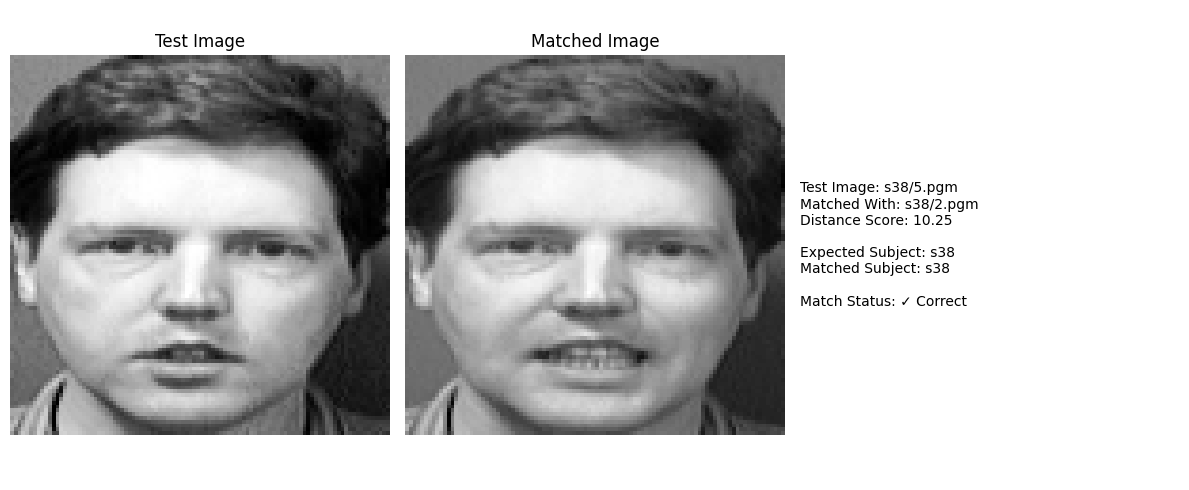

In [28]:
# Step 7: Recognize a New Face
def recognize_face(new_img, pca, mean_face, face_weights, filenames):
    if isinstance(new_img, str):
        # If input is a path
        new_img = cv2.imread(new_img, cv2.IMREAD_GRAYSCALE)
        if new_img is None:
            raise FileNotFoundError(f"Could not load image: {new_img}")
        new_img = cv2.resize(new_img, (100, 100)).flatten()
    # If input is already an image array, use it directly
    new_img_adjusted = new_img - mean_face  # Subtract mean face
    new_img_weights = pca.transform([new_img_adjusted])  # Project to Eigenface space

    # Find the closest match
    distances = np.linalg.norm(face_weights - new_img_weights, axis=1)
    best_match_index = np.argmin(distances)
    return filenames[best_match_index], distances[best_match_index]







#      * Shows test image alongside its match
#      * Displays match information and statistics
def plot_comparison(test_image, match_filename, folder_path, test_filename, distance):
    fig = plt.figure(figsize=(12, 5))

    # Create a larger figure with space for text
    gs = plt.GridSpec(1, 3, width_ratios=[1, 1, 1])

    # Plot test image
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(test_image.reshape(100, 100), cmap='gray')
    ax1.set_title('Test Image')
    ax1.axis('off')

    # Plot matched image
    ax2 = fig.add_subplot(gs[1])
    match_path = os.path.join(folder_path, match_filename)
    match_image = cv2.imread(match_path, cv2.IMREAD_GRAYSCALE)
    match_image = cv2.resize(match_image, (100, 100))
    ax2.imshow(match_image, cmap='gray')
    ax2.set_title('Matched Image')
    ax2.axis('off')

    # Add text information
    ax3 = fig.add_subplot(gs[2])
    ax3.axis('off')
    info_text = (
        f"Test Image: {test_filename}\n"
        f"Matched With: {match_filename}\n"
        f"Distance Score: {distance:.2f}\n\n"
        f"Expected Subject: {test_filename.split('/')[0]}\n"
        f"Matched Subject: {match_filename.split('/')[0]}\n\n"
        f"Match Status: "
        f"{'✓ Correct' if test_filename.split('/')[0] == match_filename.split('/')[0] else '✗ Incorrect'}"
    )
    ax3.text(0, 0.5, info_text, fontsize=10, va='center')

    plt.tight_layout()
    plt.show()

# Test one random held-out image
print("\nTesting random held-out image:")
random_idx = np.random.randint(len(test_images))
test_image = test_images[random_idx]
test_filename = test_filenames[random_idx]

match, dist = recognize_face(test_image, pca, mean_face, face_weights, filenames)
print(f"\nTest image: {test_filename}")
print(f"Recognized as: {match}")
print(f"Distance: {dist}")
print(f"Expected person: {test_filename.split('/')[0]}")
print(f"Matched with person: {match.split('/')[0]}")

# Use the enhanced visualization
plot_comparison(test_image, match, folder_path, test_filename, dist)


# Reconstruction

     * Shows face reconstruction using different numbers of eigenfaces
     * Demonstrates PCA compression effects


Trying random faces:


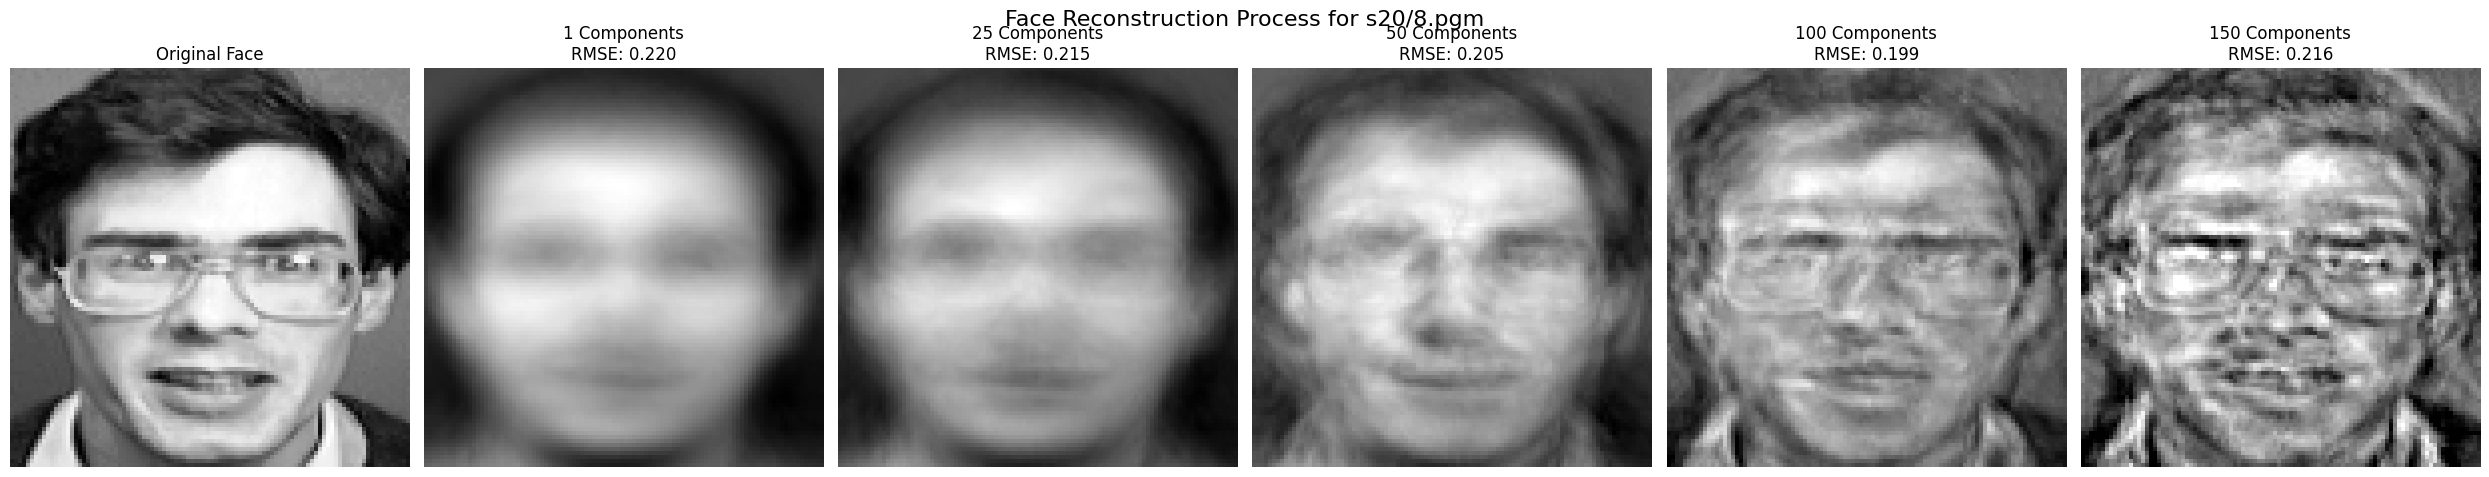

In [50]:
def show_face_reconstruction(face_index=None):
    if face_index is None:
        face_index = np.random.randint(0, len(images))

    # Get original face and normalize
    original_face = images[face_index]

    # Center the face
    centered_face = original_face - mean_face

    components_list = [1, 25, 50, 100, 150]  # More gradual progression

    fig, axes = plt.subplots(1, len(components_list) + 1, figsize=(25, 5))
    fig.suptitle(f'Face Reconstruction Process for {filenames[face_index]}', fontsize=16)

    # Show original face
    axes[0].imshow(original_face.reshape(100, 100), cmap='gray')
    axes[0].set_title('Original Face')
    axes[0].axis('off')

    for idx, n_comp in enumerate(components_list):
        # Project and reconstruct
        weights = pca.transform([centered_face])[:, :n_comp]
        reconstruction = mean_face + np.dot(weights, eigenfaces[:n_comp, :]).flatten()




        # Proper scaling back to image range
        reconstruction = np.clip(reconstruction, 0, 1)  # Clip to valid range

        # Calculate error using RMSE
        rmse = np.sqrt(np.mean((original_face - reconstruction) ** 2))

        # Show reconstruction,roor mean sqaure error
        axes[idx + 1].imshow(reconstruction.reshape(100, 100), cmap='gray')
        axes[idx + 1].set_title(f'{n_comp} Components\nRMSE: {rmse:.3f}')
        axes[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Try reconstruction with random faces
print("\nTrying random faces:")
for _ in range(1):
    show_face_reconstruction()  # Will pick random face each time


Analyzing distances for chosen test image: s12/5.pgm

Debugging distance calculations:
Test image: s12/5.pgm

Closest 5 individual images:
Distance 14.42: s12/2.pgm
Distance 15.21: s12/7.pgm
Distance 15.90: s30/7.pgm
Distance 16.10: s12/10.pgm
Distance 16.24: s12/9.pgm


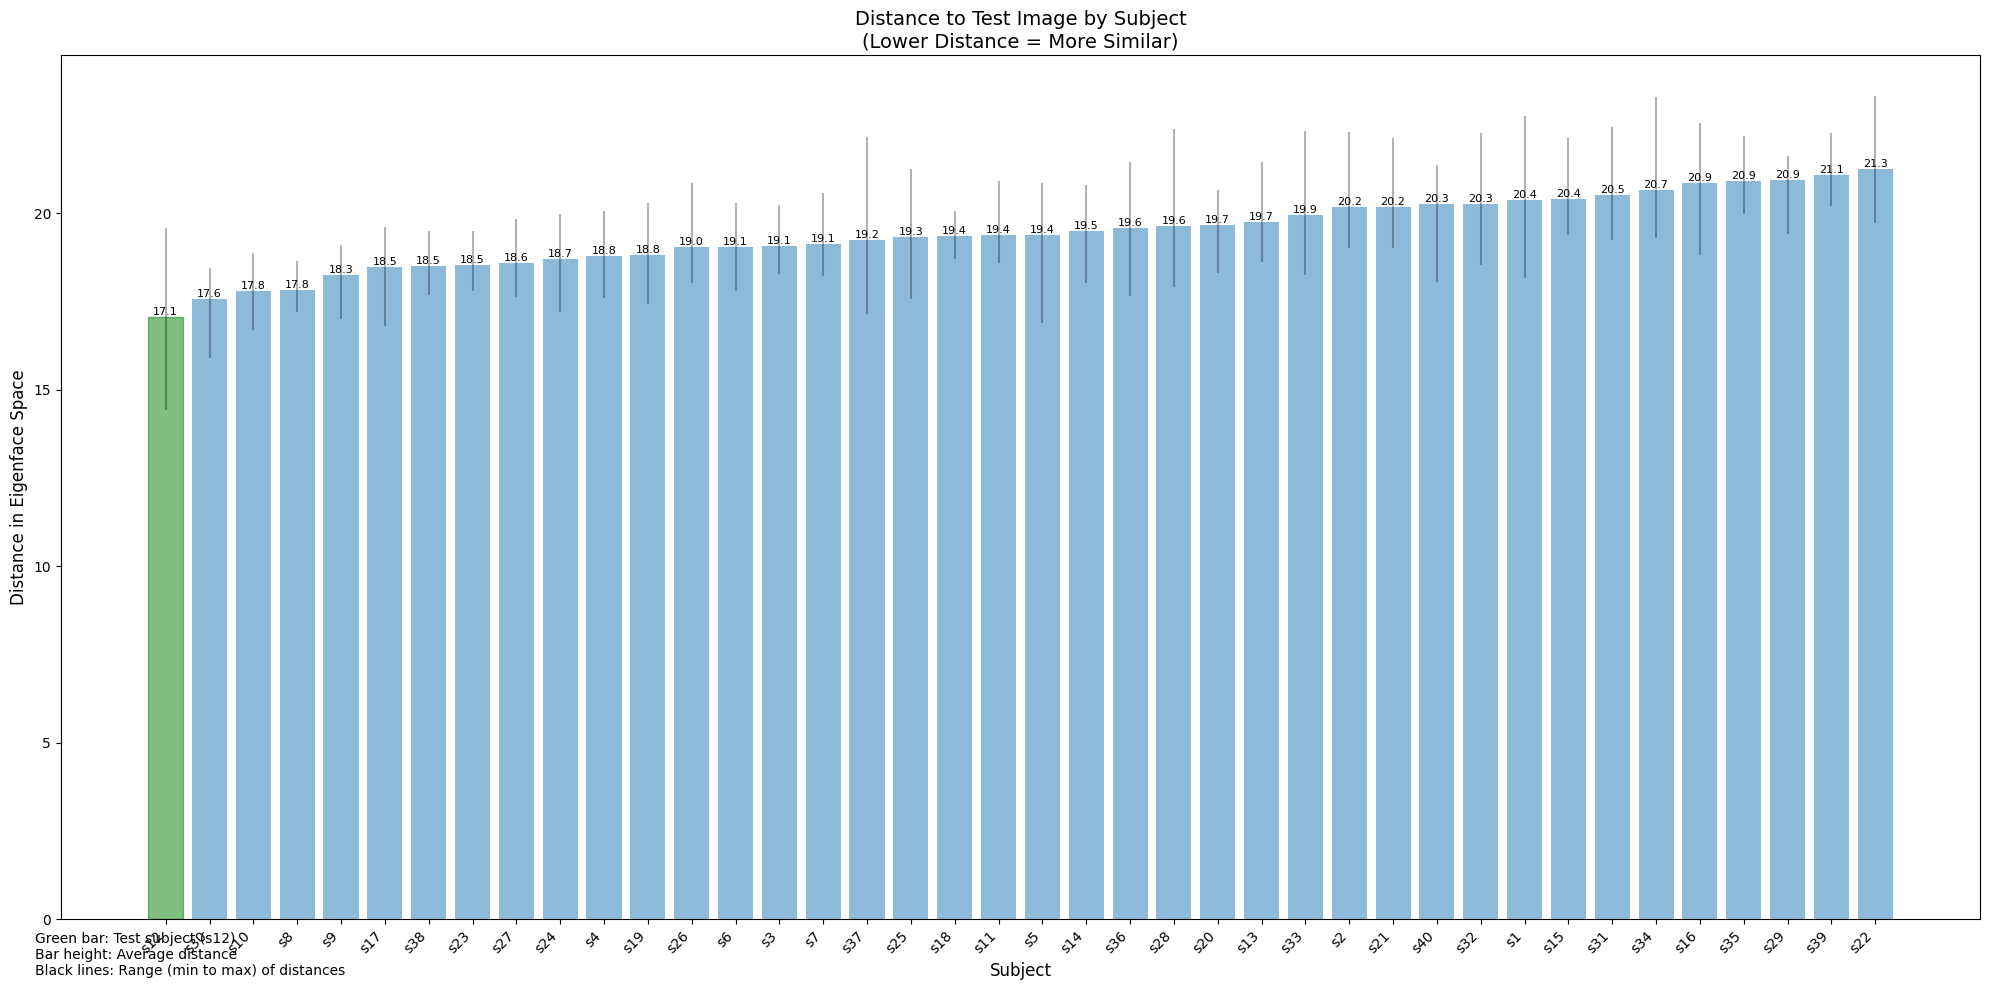


Distance Rankings (from most similar to least similar):
Subject: (min, mean, max)
s12: (14.4, 17.1, 19.6)
s30: (15.9, 17.6, 18.4)
s10: (16.7, 17.8, 18.9)
s8: (17.2, 17.8, 18.7)
s9: (17.0, 18.3, 19.1)
s17: (16.8, 18.5, 19.6)
s38: (17.7, 18.5, 19.5)
s23: (17.8, 18.5, 19.5)
s27: (17.6, 18.6, 19.8)
s24: (17.2, 18.7, 20.0)


In [30]:

# graph of distance to test image by subject
def analyze_distances(test_image, test_filename, pca, mean_face, face_weights, filenames):
    """Analyze distances between a test image and all subjects"""

    test_adjusted = test_image - mean_face
    test_weights = pca.transform([test_adjusted])
    all_distances = np.linalg.norm(face_weights - test_weights, axis=1)

    # Add debugging information
    print("\nDebugging distance calculations:")
    print(f"Test image: {test_filename}")
    print("\nClosest 5 individual images:")
    closest_indices = np.argsort(all_distances)[:5]
    for idx in closest_indices:
        print(f"Distance {all_distances[idx]:.2f}: {filenames[idx]}")

    # Create a dictionary to store distances by subject
    subject_distances = {}
    for dist, filename in zip(all_distances, filenames):
        subject = filename.split('/')[0]
        if subject not in subject_distances:
            subject_distances[subject] = []
        subject_distances[subject].append(dist)

    # Calculate mean, min, and max distance per subject
    subject_stats = {}
    for subject, distances in subject_distances.items():
        subject_stats[subject] = {
            'mean': np.mean(distances),
            'min': np.min(distances),
            'max': np.max(distances)
        }

    # Sort subjects by mean distance
    sorted_subjects = sorted(subject_stats.items(), key=lambda x: x[1]['mean'])

    # Create visualization
    plt.figure(figsize=(20, 10))

    subjects = [s[0] for s in sorted_subjects]
    means = [s[1]['mean'] for s in sorted_subjects]
    mins = [s[1]['min'] for s in sorted_subjects]
    maxs = [s[1]['max'] for s in sorted_subjects]

    # Plot mean distances as bars
    bars = plt.bar(subjects, means, alpha=0.5)

    # Add error bars to show min/max range
    plt.vlines(range(len(subjects)), mins, maxs, color='black', alpha=0.3)

    plt.title('Distance to Test Image by Subject\n(Lower Distance = More Similar)', fontsize=14)
    plt.xlabel('Subject', fontsize=12)
    plt.ylabel('Distance in Eigenface Space', fontsize=12)

    # Color the correct subject differently
    test_subject = test_filename.split('/')[0]
    for idx, bar in enumerate(bars):
        if subjects[idx] == test_subject:
            bar.set_color('green')

    # Add value labels for mean distances
    for idx, bar in enumerate(bars):
        height = means[idx]
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=8)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add legend explaining the visualization
    plt.figtext(0.02, 0.02,
                f"Green bar: Test subject ({test_subject})\n" +
                "Bar height: Average distance\n" +
                "Black lines: Range (min to max) of distances",
                fontsize=10)

    plt.tight_layout()
    plt.show()

    return sorted_subjects

# Test with a specific image (for example, s1/1.pgm)
chosen_filename = "s12/5.pgm"
chosen_idx = next(i for i, f in enumerate(test_filenames) if chosen_filename in f)
test_image = test_images[chosen_idx]
test_filename = test_filenames[chosen_idx]

print(f"\nAnalyzing distances for chosen test image: {test_filename}")
sorted_distances = analyze_distances(test_image, test_filename, pca, mean_face, face_weights, filenames)

print("\nDistance Rankings (from most similar to least similar):")
print("Subject: (min, mean, max)")
for subject, stats in sorted_distances[:10]:  # Show top 10
    print(f"{subject}: ({stats['min']:.1f}, {stats['mean']:.1f}, {stats['max']:.1f})")




Processing image from Google Drive...
Original image dimensions: (754, 504)
Resized to: (100, 100)


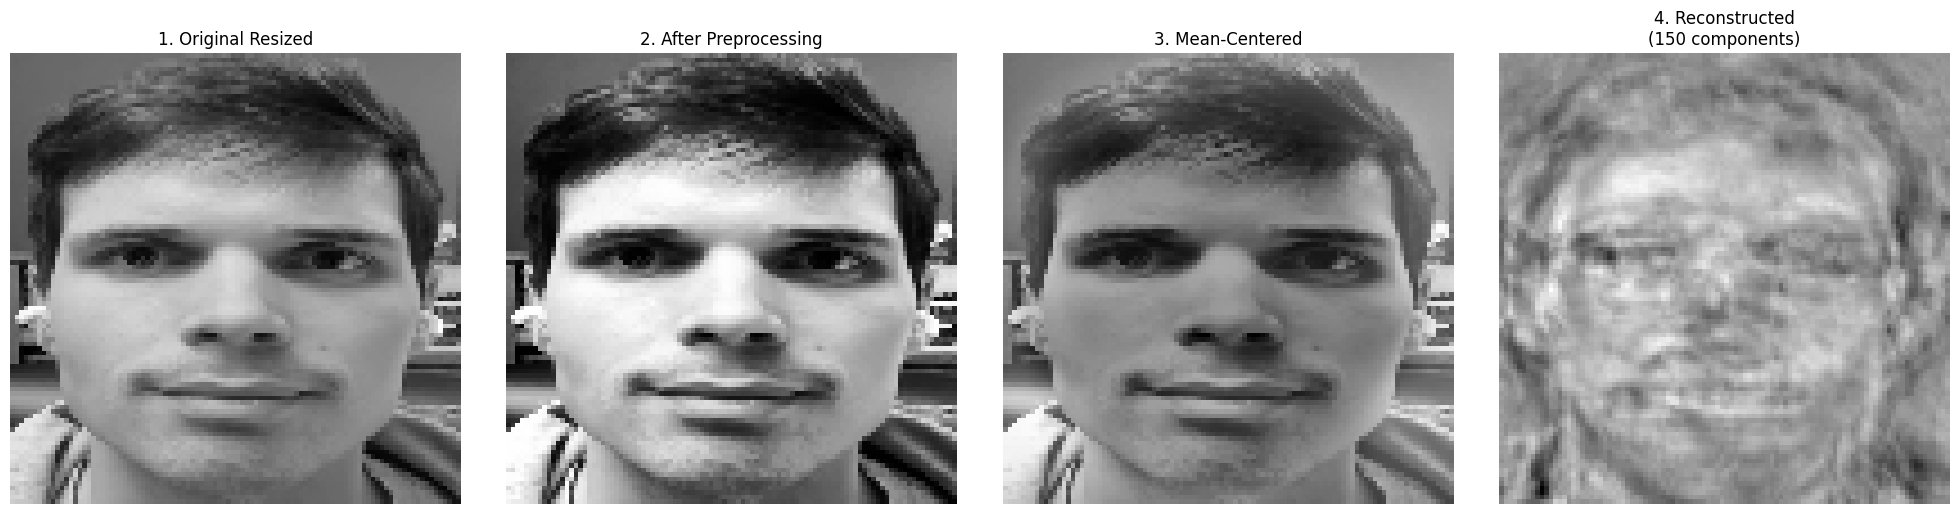


Reconstruction info:
Number of components used: 150
First few eigenface weights: [ 0.84632609 -1.37474383  0.19625745  1.28209128  1.95714137]


In [31]:


def process_single_image(image_path, pca, mean_face, img_size=(100, 100)):
    """
    Process a single image and show its eigenface reconstruction
    """
    # Load and show original dimensions
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error loading image: {image_path}")
        return

    print(f"Original image dimensions: {img.shape}")

    # Resize and preprocess
    img = cv2.resize(img, img_size)
    print(f"Resized to: {img.shape}")

    # Show intermediate steps
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('1. Original Resized')
    axes[0].axis('off')

    # After preprocessing
    img = preprocess_image(img)
    axes[1].imshow(img, cmap='gray')
    axes[1].set_title('2. After Preprocessing')
    axes[1].axis('off')

    # Flatten and center
    img_flat = img.flatten()
    img_centered = img_flat - mean_face
    axes[2].imshow(img_centered.reshape(img_size), cmap='gray')
    axes[2].set_title('3. Mean-Centered')
    axes[2].axis('off')

    # Transform and reconstruct
    weights = pca.transform([img_centered])
    reconstruction = mean_face + np.dot(weights, eigenfaces[:pca.n_components, :]).flatten()
    axes[3].imshow(reconstruction.reshape(img_size), cmap='gray')
    axes[3].set_title(f'4. Reconstructed\n({pca.n_components} components)')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    return weights, reconstruction


# Process your own image
folder_path_images = "/content/drive/My Drive/images"
joe_image_path = os.path.join(folder_path_images, "joe.jpg")

print("\nProcessing image from Google Drive...")
weights, reconstruction = process_single_image(joe_image_path, pca, mean_face)

# Aadditional information about the reconstruction
print(f"\nReconstruction info:")
print(f"Number of components used: {pca.n_components}")
print(f"First few eigenface weights: {weights[0][:5]}")  # Show first 5 weights